## Measuring rotation in Psc-Eri

[Curtis et al. (2019)](https://arxiv.org/pdf/1905.10588.pdf) measured rotation for the Meingast et al. (2019) members o the Psc-Eri stellar stream, and found a clear co-eval structure in rotation-colour space.

Here, we will attempt to recover that same co-eval structure in the 101 stars targeted in that study, using `michael` only.

In [1]:
from michael import janet
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
cmap = sns.color_palette('colorblind', 8)

from jax import random
rng = random.PRNGKey(53)

from astroquery.vizier import Vizier
from astropy.coordinates import Angle
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')

Hi there. Welcome to the good place.


In [2]:
cat = Vizier(catalog ='J/AJ/158/77/table2',
       columns = ['Source', 'RA_ICRS', 'DE_ICRS', 'GBP-GRP', 'Teff', 'Gmag','GMag', 'Prot'])
cat.ROW_LIMIT = -1
psceri_full = cat.get_catalogs(cat.catalog)[0]

In [5]:
from tqdm import tqdm

N = len(psceri_full)

df = pd.DataFrame(index = range(N), columns=['P', 'Perr', 'Pflag'])

for idx in tqdm(np.arange(20, N+1)):
    psceri = psceri_full[idx]
    source = psceri['Source']

    ra_str = psceri['RA_ICRS'].split(' ')
    units_ra = ['h','m','s']
    rep = ''.join([ra_str[i]+units_ra[i] for i in range(3)])
    ra = Angle(rep).to(u.deg)

    dec_str = psceri['DE_ICRS'].split(' ')
    units_dec = ['d','m','s']
    rep = ''.join([dec_str[i]+units_dec[i] for i in range(3)])
    dec = Angle(rep).to(u.deg)

    j = janet(source, ra, dec,
              output_path = "/Users/oliver hall/Research/michael/Examples/PscEri",
              verbose = False)
    
    try:
        j.run(period_range = (0.1, 13.4))
    except:
        continue
    
    df.loc[idx, 'P']= j.results.loc['best', 'overall']
    df.loc[idx, 'Perr']= j.results.loc['best', 'e_overall']
    df.loc[idx, 'Pflag']= j.results.loc['best', 'f_overall']
df['PC'] = np.array(psceri_full['Prot'].data)
df.to_csv('PscEri/PscEri_periods.csv')

  0%|                                                    | 0/82 [00:00<?, ?it/s]

No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

  1%|▌                                        | 1/82 [03:27<4:39:55, 207.35s/it]

No postcard object will be created for this target.


  0%|          | 0/22549 [00:00<?, ?it/s]

  2%|█                                        | 2/82 [06:27<4:15:09, 191.37s/it]

No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

  4%|█▌                                       | 3/82 [09:11<3:55:42, 179.02s/it]

No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

  5%|██                                       | 4/82 [14:21<4:59:32, 230.42s/it]

Found star in Sector(s) 4 31


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-1-4-cal-1294-1672_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-1-4-cal-1294-1672_tess_v2_bkg.fits with expected size 65286720.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0004-1-4-cal-1294-1672_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0004-1-4-cal-1294-1672_tess_v2_bkg.fits with expected size 65286720. [astroquery.query]


 [Done]
No eleanor postcard has been made for your target (yet). Using TessCut instead.


  6%|██▌                                      | 5/82 [14:37<3:16:49, 153.38s/it]

Inflating...
Found star in Sector(s) 5 5 32


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_bkg.fits with expected size 73658880.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc.fits with expected size 147421440.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc.fits with expected size 147421440. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1_tess_v2_pm.txt with expected size 221849.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-1-cal-2018-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-1_tess_v2_pm.txt with expected size 221849. [astroquery.query]
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


  7%|███                                      | 6/82 [15:49<2:39:17, 125.76s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22619 [00:00<?, ?it/s]

  9%|███▌                                     | 7/82 [19:02<3:04:21, 147.48s/it]

Found star in Sector(s) 4
No postcard object will be created for this target.


  0%|          | 0/758 [00:00<?, ?it/s]

 10%|████                                     | 8/82 [19:55<2:24:54, 117.49s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 11%|████▌                                    | 9/82 [22:57<2:47:40, 137.82s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22698 [00:00<?, ?it/s]

 12%|████▉                                   | 10/82 [26:47<3:19:14, 166.04s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22699 [00:00<?, ?it/s]

 13%|█████▎                                  | 11/82 [30:22<3:34:09, 180.98s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22543 [00:00<?, ?it/s]

 15%|█████▊                                  | 12/82 [33:37<3:36:11, 185.31s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

 16%|██████▎                                 | 13/82 [36:40<3:32:30, 184.80s/it]

Found star in Sector(s) 5 6 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22695 [00:00<?, ?it/s]

 17%|██████▊                                 | 14/82 [42:16<4:21:01, 230.32s/it]

Found star in Sector(s) 4 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 18%|███████▎                                | 15/82 [47:21<4:42:13, 252.74s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

 20%|███████▊                                | 16/82 [50:26<4:15:48, 232.55s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22660 [00:00<?, ?it/s]

 21%|████████▎                               | 17/82 [53:55<4:04:03, 225.28s/it]

Found star in Sector(s) 4 30 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 22%|████████▎                             | 18/82 [1:00:08<4:47:45, 269.78s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22701 [00:00<?, ?it/s]

 23%|████████▊                             | 19/82 [1:03:27<4:21:00, 248.57s/it]

Found star in Sector(s) 3 4 30 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/23366 [00:00<?, ?it/s]

 24%|█████████▎                            | 20/82 [1:11:36<5:31:32, 320.84s/it]

Found star in Sector(s) 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/21811 [00:00<?, ?it/s]

 26%|█████████▋                            | 21/82 [1:14:56<4:49:14, 284.50s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22705 [00:00<?, ?it/s]

 27%|██████████▏                           | 22/82 [1:18:13<4:18:04, 258.07s/it]

Found star in Sector(s) 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/21808 [00:00<?, ?it/s]

 28%|██████████▋                           | 23/82 [1:21:29<3:55:34, 239.57s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22710 [00:00<?, ?it/s]

 29%|███████████                           | 24/82 [1:24:59<3:43:03, 230.76s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22704 [00:00<?, ?it/s]

 30%|███████████▌                          | 25/82 [1:28:17<3:29:46, 220.81s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

 32%|████████████                          | 26/82 [1:31:28<3:17:38, 211.76s/it]

Found star in Sector(s) 5 5 32 32


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_bkg.fits with expected size 73658880.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc.fits with expected size 147421440.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc.fits with expected size 147421440. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-2_tess_v2_pm.txt with expected size 222649.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-2-cal-0510-0052_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-2_tess_v2_pm.txt with expected size 222649. [astroquery.query]
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No eleanor postcard has been made for your target (yet). Using TessCut instead.


 33%|████████████▌                         | 27/82 [1:32:37<2:35:01, 169.13s/it]

Found star in Sector(s) 5 6 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22702 [00:00<?, ?it/s]

 34%|████████████▉                         | 28/82 [1:37:38<3:07:54, 208.78s/it]

Found star in Sector(s) 4 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 35%|█████████████▍                        | 29/82 [1:42:37<3:28:11, 235.68s/it]

Found star in Sector(s) 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/21814 [00:00<?, ?it/s]

 37%|█████████████▉                        | 30/82 [1:45:53<3:14:03, 223.91s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22699 [00:00<?, ?it/s]

 38%|██████████████▎                       | 31/82 [1:49:06<3:02:23, 214.58s/it]

No postcard object will be created for this target.


  0%|          | 0/22566 [00:00<?, ?it/s]

 39%|██████████████▊                       | 32/82 [1:51:26<2:40:05, 192.10s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22634 [00:00<?, ?it/s]

 40%|███████████████▎                      | 33/82 [1:54:46<2:38:45, 194.41s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22700 [00:00<?, ?it/s]

 41%|███████████████▊                      | 34/82 [1:57:59<2:35:22, 194.22s/it]

Found star in Sector(s) 5
No postcard object will be created for this target.


  0%|          | 0/756 [00:00<?, ?it/s]

 43%|████████████████▏                     | 35/82 [1:58:49<1:58:03, 150.70s/it]

Found star in Sector(s) 4
No postcard object will be created for this target.


  0%|          | 0/762 [00:00<?, ?it/s]

 44%|████████████████▋                     | 36/82 [1:59:33<1:31:02, 118.76s/it]

Found star in Sector(s) 2
No postcard object will be created for this target.


  0%|          | 0/816 [00:00<?, ?it/s]

 45%|█████████████████▌                     | 37/82 [2:00:25<1:14:07, 98.84s/it]

Found star in Sector(s) 5 6 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22709 [00:00<?, ?it/s]

 46%|█████████████████▌                    | 38/82 [2:05:35<1:58:49, 162.03s/it]

Found star in Sector(s) 5 31 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22697 [00:00<?, ?it/s]

 48%|██████████████████                    | 39/82 [2:11:43<2:40:30, 223.96s/it]

Found star in Sector(s) 4 5 31 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/23513 [00:00<?, ?it/s]

 49%|██████████████████▌                   | 40/82 [2:20:12<3:36:41, 309.57s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 50%|███████████████████                   | 41/82 [2:23:15<3:05:31, 271.50s/it]

Found star in Sector(s) 4 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22619 [00:00<?, ?it/s]

 51%|███████████████████▍                  | 42/82 [2:28:04<3:04:29, 276.73s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22660 [00:00<?, ?it/s]

 52%|███████████████████▉                  | 43/82 [2:31:28<2:45:39, 254.86s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 54%|████████████████████▍                 | 44/82 [2:34:31<2:27:52, 233.48s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22547 [00:00<?, ?it/s]

 55%|████████████████████▊                 | 45/82 [2:37:47<2:16:58, 222.13s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22631 [00:00<?, ?it/s]

 56%|█████████████████████▎                | 46/82 [2:41:06<2:09:09, 215.25s/it]

Found star in Sector(s) 2
No postcard object will be created for this target.


  0%|          | 0/800 [00:00<?, ?it/s]

 57%|█████████████████████▊                | 47/82 [2:41:58<1:36:55, 166.16s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22698 [00:00<?, ?it/s]

 59%|██████████████████████▏               | 48/82 [2:45:26<1:41:17, 178.74s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

 60%|██████████████████████▋               | 49/82 [2:48:31<1:39:22, 180.67s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22660 [00:00<?, ?it/s]

 61%|███████████████████████▏              | 50/82 [2:51:57<1:40:23, 188.25s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

 62%|███████████████████████▋              | 51/82 [2:55:12<1:38:20, 190.34s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22630 [00:00<?, ?it/s]

 63%|████████████████████████              | 52/82 [2:58:33<1:36:41, 193.37s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22694 [00:00<?, ?it/s]

 65%|████████████████████████▌             | 53/82 [3:01:58<1:35:09, 196.89s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 66%|█████████████████████████             | 54/82 [3:05:07<1:30:49, 194.64s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22619 [00:00<?, ?it/s]

 67%|█████████████████████████▍            | 55/82 [3:08:01<1:24:48, 188.46s/it]

Found star in Sector(s) 4 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/21820 [00:00<?, ?it/s]

 68%|█████████████████████████▉            | 56/82 [3:11:22<1:23:11, 191.99s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22660 [00:00<?, ?it/s]

 70%|██████████████████████████▍           | 57/82 [3:14:44<1:21:15, 195.01s/it]

Found star in Sector(s) 5
No postcard object will be created for this target.


  0%|          | 0/752 [00:00<?, ?it/s]

 71%|██████████████████████████▉           | 58/82 [3:15:45<1:01:58, 154.93s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22545 [00:00<?, ?it/s]

 72%|███████████████████████████▎          | 59/82 [3:18:51<1:02:59, 164.35s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 73%|███████████████████████████▊          | 60/82 [3:21:53<1:02:12, 169.67s/it]

Found star in Sector(s) 2 29
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22660 [00:00<?, ?it/s]

 74%|████████████████████████████▎         | 61/82 [3:25:20<1:03:15, 180.76s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22695 [00:00<?, ?it/s]

 76%|████████████████████████████▋         | 62/82 [3:28:35<1:01:39, 184.96s/it]

Found star in Sector(s) 5 32


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_bkg.fits with expected size 73658880.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc.fits with expected size 147421440.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc.fits with expected size 147421440. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-4_tess_v2_pm.txt with expected size 223452.


INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-2-4-cal-0216-0106_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-2-4_tess_v2_pm.txt with expected size 223452. [astroquery.query]
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22696 [00:00<?, ?it/s]

 77%|██████████████████████████████▋         | 63/82 [3:31:23<57:00, 180.02s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22703 [00:00<?, ?it/s]

 78%|███████████████████████████████▏        | 64/82 [3:34:38<55:17, 184.30s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22703 [00:00<?, ?it/s]

 79%|███████████████████████████████▋        | 65/82 [3:37:57<53:30, 188.87s/it]

Found star in Sector(s) 5 32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22697 [00:00<?, ?it/s]

 80%|████████████████████████████████▏       | 66/82 [3:41:10<50:42, 190.18s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 82%|████████████████████████████████▋       | 67/82 [3:44:12<46:52, 187.49s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22622 [00:00<?, ?it/s]

 83%|█████████████████████████████████▏      | 68/82 [3:47:17<43:34, 186.76s/it]

Found star in Sector(s) 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22619 [00:00<?, ?it/s]

 84%|█████████████████████████████████▋      | 69/82 [3:50:14<39:52, 184.05s/it]

Found star in Sector(s) 3 4 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22565 [00:00<?, ?it/s]

 85%|██████████████████████████████████▏     | 70/82 [3:55:17<43:55, 219.62s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22562 [00:00<?, ?it/s]

 87%|██████████████████████████████████▋     | 71/82 [3:58:34<39:02, 212.97s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22546 [00:00<?, ?it/s]

 88%|███████████████████████████████████     | 72/82 [4:01:40<34:06, 204.69s/it]

Found star in Sector(s) 3 4 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/23366 [00:00<?, ?it/s]

 89%|███████████████████████████████████▌    | 73/82 [4:06:21<34:08, 227.61s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22547 [00:00<?, ?it/s]

 90%|████████████████████████████████████    | 74/82 [4:09:32<28:52, 216.61s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22547 [00:00<?, ?it/s]

 91%|████████████████████████████████████▌   | 75/82 [4:12:09<23:10, 198.65s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22545 [00:00<?, ?it/s]

 93%|█████████████████████████████████████   | 76/82 [4:15:20<19:39, 196.62s/it]

Found star in Sector(s) 4 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22621 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▌  | 77/82 [4:20:13<18:46, 225.38s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22565 [00:00<?, ?it/s]

 95%|██████████████████████████████████████  | 78/82 [4:23:20<14:15, 213.80s/it]

Found star in Sector(s) 4 5 31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/22619 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▌ | 79/82 [4:28:17<11:56, 238.98s/it]

Found star in Sector(s) 3 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.


  0%|          | 0/22562 [00:00<?, ?it/s]

 98%|███████████████████████████████████████ | 80/82 [4:31:35<07:33, 226.58s/it]

Found star in Sector(s) 2 3 29 30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...
No postcard object will be created for this target.
No postcard object will be created for this target.


  0%|          | 0/23505 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▌| 81/82 [4:40:33<03:27, 207.82s/it]


IndexError: index 101 out of range for table with length 101

In [29]:
j.decode(500)


------ Decoding Overall Period Flag 500 ------
256: The ACF period is potentially a harmonic of the 'best' period (or vice versa!)
128: The ACF period does not match the 'best' period within 2 sigma.
64: No ACF period could be reliably measured (indicating low power or long periods).
32: No robust matches were found between the SW period and any unflagged SLS periods.
16: Valididation between WS and SLS was done using a SLS period that was not the 'best' SLS value (lowest uncertainty without flags), because there was no 2 sigma agreement with the SW period.
4: Best rotation is from the Simple Autocorrelation Function (ACF) method.

No other flags raised. 



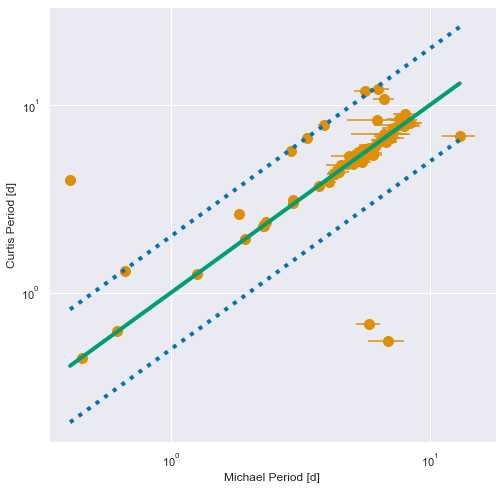

In [31]:
sns.set_style('darkgrid')
cmap = sns.color_palette('colorblind', 8)

s = df.Pflag <= 256

fig = plt.figure(figsize=(8,8))
plt.scatter(df.P[s], psceri_full['Prot'][s], s=100, c=cmap[1])
plt.errorbar(df.P[s], psceri_full['Prot'][s], xerr=df.Perr[s], fmt='|', zorder=0, c=cmap[1])

x = np.linspace(df.P.min(), df.P.max())
plt.plot(x, 2*x, ls=':', lw=4, c=cmap[0])
plt.plot(x, 0.5*x, ls=':', lw=4, c= cmap[0])
plt.plot(x, x, lw=4, c=cmap[2])

plt.xlabel('Michael Period [d]')
plt.ylabel('Curtis Period [d]')
plt.yscale('log')
plt.xscale('log')

In [32]:
psceri_full

Source,RA_ICRS,DE_ICRS,GBP-GRP,Teff,Gmag,GMag,Prot
,"""h:m:s""","""d:m:s""",mag,K,mag,mag,d
int64,str10,str11,float32,int16,float32,float32,float32
3198972700981234048,04 22 31.5,-07 33 03.2,0.432,7187,8.903,2.802,0.52
5181474045115843072,03 10 47.3,-06 34 29.8,0.446,7161,8.562,2.954,0.87
2516948215250061568,02 20 22.6,+05 52 59.1,0.597,6622,9.183,3.534,0.82
3245408684793798528,04 02 15.4,-05 53 48.2,0.604,6573,9.425,3.513,0.56
6628071944405827712,22 36 31.1,-21 35 06.0,0.647,6320,8.967,3.835,0.94
2988966044497883392,05 22 51.9,-11 47 47.8,0.648,6487,10.345,3.688,0.79
...,...,...,...,...,...,...,...
2480756793589426944,01 33 49.3,-04 28 41.7,1.670,4228,13.216,7.682,6.50


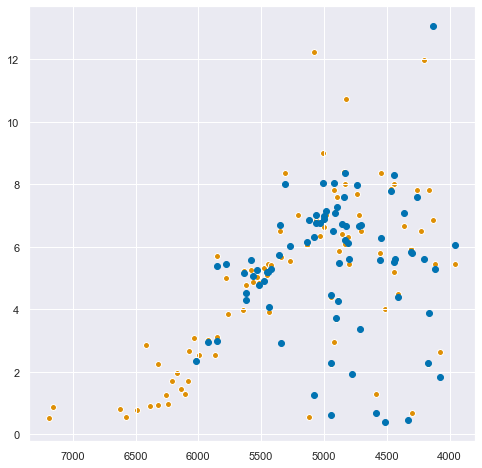

In [38]:
fig = plt.figure(figsize=(8,8))
plt.scatter(psceri_full['Teff'], df.P, zorder=1)
plt.scatter(psceri_full['Teff'], psceri_full['Prot'], zorder=0, ec='w')
plt.gca().invert_xaxis()

<AxesSubplot:xlabel='P', ylabel='Density'>

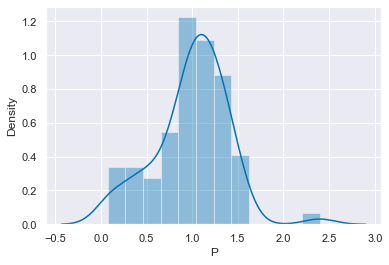

In [45]:
sns.distplot(df.P/ psceri['Prot'])